### Importing pytorch, numpy, matplotlib

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [13]:
class ProbabilisticRBM(nn.Module):
    def __init__(self, num_visible, num_hidden):
        super(ProbabilisticRBM, self).__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.weights = nn.Parameter(torch.randn(num_visible, num_hidden))
        self.visible_bias = nn.Parameter(torch.zeros(num_visible))
        self.hidden_bias = nn.Parameter(torch.zeros(num_hidden))

    def forward(self, visible):
        hidden_activations_prob = torch.sigmoid(torch.matmul(visible, self.weights) + self.hidden_bias)
        hidden_activations = torch.bernoulli(hidden_activations_prob)
        reconstructed_visible_prob = torch.sigmoid(torch.matmul(hidden_activations, self.weights.t()) + self.visible_bias)
        reconstructed_visible = torch.bernoulli(reconstructed_visible_prob)
        return reconstructed_visible, hidden_activations

    def free_energy(self, visible):
        visible_term = torch.matmul(visible, self.visible_bias)
        hidden_term = torch.sum(torch.log(1 + torch.exp(torch.matmul(visible, self.weights) + self.hidden_bias)), dim=1)
        return -visible_term - hidden_term

    def contrastive_divergence(self, input_data, k=1, lr=0.1):
        positive_hidden_activations = torch.sigmoid(torch.matmul(input_data, self.weights) + self.hidden_bias)
        positive_hidden_sample = torch.bernoulli(positive_hidden_activations)
        positive_associations = torch.matmul(input_data.t(), positive_hidden_activations)

        for step in range(k):
            if step == 0:
                hidden_sample = positive_hidden_sample
                negative_visible_prob = torch.sigmoid(torch.matmul(hidden_sample, self.weights.t()) + self.visible_bias)
                negative_visible_sample = torch.bernoulli(negative_visible_prob)
                negative_hidden_activations = torch.sigmoid(torch.matmul(negative_visible_sample, self.weights) + self.hidden_bias)
                negative_hidden_sample = torch.bernoulli(negative_hidden_activations)
                negative_associations = torch.matmul(negative_visible_sample.t(), negative_hidden_activations)
            else:
                negative_visible_prob = torch.sigmoid(torch.matmul(negative_hidden_sample, self.weights.t()) + self.visible_bias)
                negative_visible_sample = torch.bernoulli(negative_visible_prob)
                negative_hidden_activations = torch.sigmoid(torch.matmul(negative_visible_sample, self.weights) + self.hidden_bias)
                negative_hidden_sample = torch.bernoulli(negative_hidden_activations)
                negative_associations = torch.matmul(negative_visible_sample.t(), negative_hidden_activations)

        with torch.no_grad():
            self.weights += lr * (positive_associations - negative_associations) / input_data.size(0)
            self.visible_bias += lr * torch.mean(input_data - negative_visible_sample, dim=0)
            self.hidden_bias += lr * torch.mean(positive_hidden_activations - negative_hidden_activations, dim=0)

In [14]:
# Example usage:
# Create a probabilistic PyTorch RBM with 10 visible units and 5 hidden units
probabilistic_rbm = ProbabilisticRBM(num_visible=10, num_hidden=5)

# Generate some dummy data (e.g., binary vectors)
data = torch.tensor(np.random.randint(0, 2, size=(100, 10)), dtype=torch.float32)


In [16]:
class RBM(nn.Module):
    def __init__(self, num_visible, num_hidden):
        super(RBM, self).__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.weights = nn.Parameter(torch.randn(num_visible, num_hidden))
        self.visible_bias = nn.Parameter(torch.zeros(num_visible))
        self.hidden_bias = nn.Parameter(torch.zeros(num_hidden))

    def forward(self, visible):
        hidden_activations = torch.sigmoid(torch.matmul(visible, self.weights) + self.hidden_bias)
        hidden_sample = torch.bernoulli(hidden_activations)
        reconstructed_visible_activations = torch.sigmoid(torch.matmul(hidden_sample, self.weights.t()) + self.visible_bias)
        return reconstructed_visible_activations, hidden_sample

    def free_energy(self, visible):
        visible_term = torch.matmul(visible, self.visible_bias)
        hidden_term = torch.sum(torch.log(1 + torch.exp(torch.matmul(visible, self.weights) + self.hidden_bias)), dim=1)
        return -visible_term - hidden_term

    def contrastive_divergence(self, input_data, k=1, lr=0.1):
        positive_hidden_activations = torch.sigmoid(torch.matmul(input_data, self.weights) + self.hidden_bias)
        positive_hidden_sample = torch.bernoulli(positive_hidden_activations)
        
        for step in range(k):
            if step == 0:
                hidden_sample = positive_hidden_sample
                negative_visible_activations = torch.sigmoid(torch.matmul(hidden_sample, self.weights.t()) + self.visible_bias)
                negative_visible_sample = torch.bernoulli(negative_visible_activations)
                negative_hidden_activations = torch.sigmoid(torch.matmul(negative_visible_sample, self.weights) + self.hidden_bias)
                negative_hidden_sample = torch.bernoulli(negative_hidden_activations)
            else:
                negative_visible_activations = torch.sigmoid(torch.matmul(negative_hidden_sample, self.weights.t()) + self.visible_bias)
                negative_visible_sample = torch.bernoulli(negative_visible_activations)
                negative_hidden_activations = torch.sigmoid(torch.matmul(negative_visible_sample, self.weights) + self.hidden_bias)
                negative_hidden_sample = torch.bernoulli(negative_hidden_activations)

        with torch.no_grad():
            positive_associations = torch.matmul(input_data.t(), positive_hidden_activations)
            negative_associations = torch.matmul(negative_visible_sample.t(), negative_hidden_activations)

            self.weights += lr * (positive_associations - negative_associations) / input_data.size(0)
            self.visible_bias += lr * torch.mean(input_data - negative_visible_sample, dim=0)
            self.hidden_bias += lr * torch.mean(positive_hidden_activations - negative_hidden_activations, dim=0)

    def compute_reconstruction_error(self, input_data):
        reconstructed_data, _ = self.forward(input_data)
        error = torch.mean((input_data - reconstructed_data)**2)
        return error.item()

In [17]:
# Example usage:
# Create an RBM with 10 visible units and 5 hidden units
rbm = RBM(num_visible=10, num_hidden=5)

# Generate some dummy data (e.g., binary vectors)
data = torch.tensor(np.random.randint(0, 2, size=(100, 10)), dtype=torch.float32)
data

tensor([[0., 1., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 1., 0., 1., 1., 1.],
        [0., 0., 0., 1., 0., 1., 1., 0., 1., 1.],
        [1., 0., 1., 0., 0., 1., 0., 0., 1., 1.],
        [1., 0., 0., 0., 1., 1., 0., 1., 0., 0.],
        [1., 1., 1., 0., 1., 0., 1., 0., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 1., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 0., 0., 0., 1., 1., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 1., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 1., 0., 1., 1., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
        [1., 1., 1., 0., 0., 1., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0., 1., 1., 0., 1.],
        [1., 1., 1., 1., 0., 1., 1., 0., 0., 1.],
        [0., 0., 1., 1., 0., 1., 1., 0., 1., 1.],
        [0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],


In [18]:
# Train the RBM on the dummy data using contrastive divergence
reconstruction_errors = []
for epoch in range(50):
    rbm.contrastive_divergence(data)
    error = rbm.compute_reconstruction_error(data)
    reconstruction_errors.append(error)


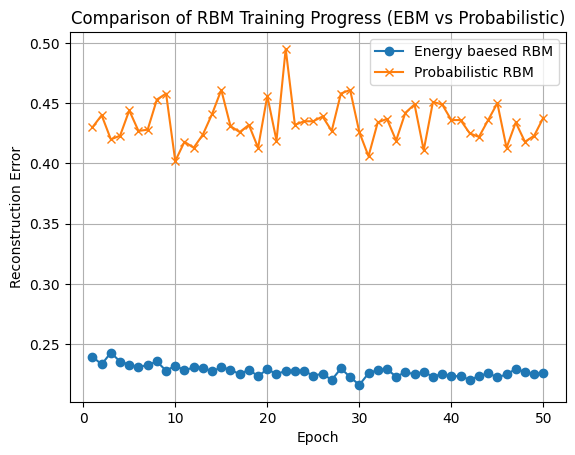

In [20]:
# Train the probabilistic PyTorch RBM on the dummy data using contrastive divergence
reconstruction_errors_probabilistic = []
for epoch in range(50):
    probabilistic_rbm.contrastive_divergence(data)
    error = torch.mean((data - probabilistic_rbm(data)[0])**2).item()  # Reconstruction error
    reconstruction_errors_probabilistic.append(error)

# Plot the reconstruction error over epochs
plt.plot(range(1, 51), reconstruction_errors, marker='o', label='Energy baesed RBM')
plt.plot(range(1, 51), reconstruction_errors_probabilistic, marker='x', label='Probabilistic RBM')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Error')
plt.title('Comparison of RBM Training Progress (EBM vs Probabilistic)')
plt.legend()
plt.grid(True)
plt.show()

# Differences Between Energy-Based Models and Probabilistic Models

## Energy-Based Models (EBMs)

Energy-based models are a class of models used in machine learning for representing probability distributions over complex data. They define a joint probability distribution over the observed variables and introduce an energy function that associates a scalar value (energy) with each possible configuration of the variables. The probability of a configuration is then related to its energy, often through a Boltzmann distribution:

\[
P(x) = \frac{e^{-E(x)}}{Z}
\]

where:
- \(x\) is a configuration of the variables.
- \(E(x)\) is the energy associated with configuration \(x\).
- \(Z\) is the partition function, ensuring that the probabilities sum to 1 over all possible configurations.

### Characteristics of Energy-Based Models:
1. **Energy Function**: EBMs define an energy function that maps configurations of variables to scalar values. This energy function captures dependencies and interactions between variables.
2. **Probability Distribution**: The probability of a configuration is inversely related to its energy, with lower energy configurations being more probable.
3. **Inference**: Inference in EBMs involves finding configurations with low energy, which correspond to probable states of the system.
4. **Training**: EBMs are trained to assign low energy to observed data and high energy to unobserved or undesirable configurations through techniques like contrastive divergence or maximum likelihood estimation.
5. **Applications**: EBMs find applications in tasks such as image generation, denoising, and anomaly detection.

## Probabilistic Models

Probabilistic models are a broad class of models that explicitly represent probability distributions over variables. They provide a principled framework for reasoning under uncertainty and modeling complex data distributions. Probabilistic models can be generative or discriminative, and they aim to capture the underlying structure of the data.

### Characteristics of Probabilistic Models:
1. **Probability Distribution**: Probabilistic models directly define a probability distribution over the observed variables, typically using parametric or non-parametric forms.
2. **Likelihood**: The likelihood function specifies the probability of observing the data given the model parameters.
3. **Inference**: Inference in probabilistic models involves estimating the posterior distribution over latent variables given observed data, often using techniques like Bayesian inference or variational inference.
4. **Training**: Probabilistic models are trained by maximizing the likelihood of the observed data, either directly or through optimization of a variational objective function.
5. **Applications**: Probabilistic models are widely used in tasks such as classification, regression, density estimation, and clustering.

## Key Differences:

1. **Representation**: Energy-based models represent distributions indirectly through an energy function, while probabilistic models directly parameterize the probability distribution.
2. **Inference Strategy**: Inference in energy-based models focuses on finding low-energy configurations, whereas probabilistic models typically involve estimating posterior distributions or making predictions based on the likelihood of observed data.
3. **Training Objective**: Energy-based models are trained to assign low energy to observed data configurations, while probabilistic models are trained to maximize the likelihood of observed data.
4. **Flexibility**: Energy-based models offer flexibility in defining the energy function, allowing for capturing complex dependencies, while probabilistic models may have more explicit assumptions about the form of the probability distribution.

Overall, while both energy-based models and probabilistic models aim to capture the underlying structure of data, they differ in their representation, inference strategy, and training objectives.
